In [ ]:
!gdown 1XFiH0-J1r9DepyhfAzQUCe8pIClddNHw
!gdown 1U-qJ0Aayp2srzlIxiztEpTjIolp9fWya
!gdown 163rDALChJadKYDgyQIDoXPxHzaKzR0gR

Downloading...
From: https://drive.google.com/uc?id=1XFiH0-J1r9DepyhfAzQUCe8pIClddNHw
To: /content/df_interest.pkl
100% 624k/624k [00:00<00:00, 72.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1U-qJ0Aayp2srzlIxiztEpTjIolp9fWya
To: /content/df_outlier.pkl
100% 171k/171k [00:00<00:00, 67.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=163rDALChJadKYDgyQIDoXPxHzaKzR0gR
To: /content/movies_information_with_embeddings.pkl
100% 47.7M/47.7M [00:00<00:00, 91.7MB/s]


In [ ]:
import pandas as pd
df_int = pd.read_pickle('df_interest.pkl')
df_out = pd.read_pickle('df_outlier.pkl')
df_movies = pd.read_pickle('movies_information_with_embeddings.pkl')

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_int, test_size=0.2, random_state = 0)

df_test = df_test[(df_test.item.isin(df_train.item.unique())) & (df_test.user.isin(df_train.user.unique()))]

df_out = df_out[(df_out.item.isin(df_train.item.unique())) & (df_out.user.isin(df_train.user.unique()))]

In [ ]:
import networkx as nx

G = nx.Graph()

for _,row in df_train.iterrows():
  user = str(row['user']) + ':user'
  item = str(row['item']) + ':item'

  keywords = df_movies[df_movies.movie_id == int(row['item'])].keywords.iloc[0]  
  genres = df_movies[df_movies.movie_id == int(row['item'])].genres.iloc[0]
  review = df_movies[df_movies.movie_id == int(row['item'])].reviews.iloc[0]

  G.add_edge(user,item)
  G.add_edge(item, str(row['item'])+':review')
  for keyword in keywords:
    G.add_edge(item,keyword['name'] + ':keyword')
  
  for genre in genres:
    G.add_edge(item,genre['name'] + ':genre')

In [ ]:
for node in G.nodes:
  if 'item' in node:
    G.nodes[node]['overview'] = df_movies[df_movies.movie_id == float(node.split(':')[0])].overview
    G.nodes[node]['features'] = df_movies[df_movies.movie_id == float(node.split(':')[0])].overview_embedding.iloc[0]
    G.nodes[node]['color'] = 'red'
    G.nodes[node]['type'] = 'item'
  elif 'user' in node:
    G.nodes[node]['color'] = 'blue'
    G.nodes[node]['type'] = 'user'
  elif 'review' in node:
    G.nodes[node]['review'] = df_movies[df_movies.movie_id == float(node.split(':')[0])].reviews
    G.nodes[node]['features'] = df_movies[df_movies.movie_id == float(node.split(':')[0])].review_embedding.iloc[0]
    G.nodes[node]['color'] = 'purple'
    G.nodes[node]['type'] = 'review'
  elif 'genre' in node:
    G.nodes[node]['genre'] = node.split(':')[0]
    G.nodes[node]['color'] = 'black'
    G.nodes[node]['type'] = 'genre'
  elif 'keyword' in node:
    G.nodes[node]['keyword'] = node.split(':')[0]
    G.nodes[node]['color'] = 'green'
    G.nodes[node]['type'] = 'keyword'

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import random


def regularization(G, dim, embedding_feature: str = 'features', iterations=15, mi=1.0):

    nodes = []

    # inicializando vetor f para todos os nodes
    for node in G.nodes():
        G.nodes[node]['f'] = np.array([0.0]*dim)
        if embedding_feature in G.nodes[node]:
            G.nodes[node]['f'] = G.nodes[node][embedding_feature]*1.0
        nodes.append(node)

    pbar = tqdm(range(0, iterations))

    for iteration in pbar:
        random.shuffle(nodes)
        energy = 0.0

        # percorrendo cada node
        for node in nodes:
            f_new = np.array([0.0]*dim)
            f_old = np.array(G.nodes[node]['f'])*1.0
            sum_w = 0.0
            w = 1.0

            # percorrendo vizinhos do node
            for neighbor in G.neighbors(node):

                w /= np.sqrt(G.degree[neighbor])
                
                f_new = f_new + (w * G.nodes[neighbor]['f'])

                sum_w += w

            f_new /= sum_w

            G.nodes[node]['f'] = f_new*1.0

            if embedding_feature in G.nodes[node]:
                G.nodes[node]['f'] = G.nodes[node][embedding_feature] * \
                    mi + G.nodes[node]['f']*(1.0-mi)

            energy += np.linalg.norm(f_new-f_old)


        iteration += 1
        message = 'Iteration '+str(iteration)+' | Energy = '+str(energy)
        pbar.set_description(message)

    return G

In [ ]:
dim = len(df_movies.review_embedding.iloc[0])

G2 = regularization(G, dim, iterations=5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
for node in G2.nodes():
  if 'features' in G2.nodes[node]:
    G2.nodes[node]['f'] = G.nodes[node]['features']

In [ ]:
!git clone https://github.com/stellargraph/stellargraph.git

Cloning into 'stellargraph'...
remote: Enumerating objects: 22627, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 22627 (delta 37), reused 61 (delta 20), pack-reused 22531
Receiving objects: 100% (22627/22627), 93.44 MiB | 22.42 MiB/s, done.
Resolving deltas: 100% (14721/14721), done.


In [ ]:
cd stellargraph

/content/stellargraph


In [ ]:
!pip install -r requirements.txt

In [ ]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets

from tensorflow.keras.callbacks import EarlyStopping
from stellargraph.utils import plot_history

import tensorflow as tf
import stellargraph
from stellargraph import StellarGraph

In [ ]:
from stellargraph import StellarGraph
G = StellarGraph.from_networkx(G2,node_features='f')
G

In [ ]:
def gcn_experimental_loop(EXPERIMENTAL_SEED, P_FRAC, epoch, patience, layer_sizes, activations, dropout, lr):

  # Define an edge splitter on the original graph G:
  edge_splitter_test = EdgeSplitter(G)

  # Randomly sample a fraction p=P_FRAC of all positive links, and same number of negative links, from G, and obtain the
  # reduced graph G_test with the sampled links removed:
  G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
      p=P_FRAC, method="global", keep_connected=True,seed=EXPERIMENTAL_SEED
  )

  # Define an edge splitter on the reduced graph G_test:
  edge_splitter_train = EdgeSplitter(G_test)

  # Randomly sample a fraction p=P_FRAC of all positive links, and same number of negative links, from G_test, and obtain the
  # reduced graph G_train with the sampled links removed:
  G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
      p=P_FRAC, method="global", keep_connected=True,seed=EXPERIMENTAL_SEED
  )

  train_gen = FullBatchLinkGenerator(G_train, method="gcn")
  train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

  test_gen = FullBatchLinkGenerator(G_test, method="gcn")
  test_flow = train_gen.flow(edge_ids_test, edge_labels_test)


  gcn = GCN(
      layer_sizes=layer_sizes, activations=activations, generator=train_gen, dropout=dropout
  )

  x_inp, x_out = gcn.in_out_tensors()

  prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

  prediction = keras.layers.Reshape((-1,))(prediction)

  model = keras.Model(inputs=x_inp, outputs=prediction)

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=lr),
      loss=keras.losses.binary_crossentropy,
      metrics=[keras.metrics.BinaryAccuracy()],
  )

  init_train_metrics = model.evaluate(train_flow)
  init_test_metrics = model.evaluate(test_flow)

  es = EarlyStopping(monitor="loss", min_delta=0, patience=patience)

  history = model.fit(
      train_flow, epochs=epoch, validation_data=test_flow, verbose=1, shuffle=False, callbacks=[es])

  train_metrics = model.evaluate(train_flow)
  test_metrics = model.evaluate(test_flow)

  print("\nTest Set Metrics of the trained model:")
  L = []
  for name, val in zip(model.metrics_names, test_metrics):
      print(name,val,len(edge_ids_train)/2,len(edge_ids_test)/2,EXPERIMENTAL_SEED,P_FRAC)
      L.append([name,val,len(edge_ids_train)/2,len(edge_ids_test)/2,EXPERIMENTAL_SEED,P_FRAC])

  return L, model, history

In [ ]:
tf.random.set_seed(81)
stellargraph.random.set_seed(81)

epoch = 200
patience = 50
n_neuron = [64, 32]
activation = ['tanh', 'tanh']
dropout = 0.3
lr = 0.001

L, model, hist = gcn_experimental_loop(81, 0.4, epoch, patience, n_neuron, activation, dropout, lr)

In [ ]:
plot_history(hist)

In [ ]:
embedding_generator = keras.Model(inputs=model.input, outputs=model.layers[5].output)

gen = FullBatchLinkGenerator(G, method="gcn")
flow = gen.flow(G2.edges, [1] * len((G2.edges)))

embeddings = embedding_generator.predict(flow)

df_gnn = pd.DataFrame(index = G2.nodes)
df_gnn['emb_gnn'] = list(embeddings[0])

In [ ]:
from sklearn.metrics import classification_report
from sklearn.svm import OneClassSVM as OCSVM

def evaluation_one_class(preds_interest, preds_outliers):
    y_true = [1] * len(preds_interest) + [-1] * len(preds_outliers)
    y_pred = list(preds_interest) + list(preds_outliers)
    return print(classification_report(y_true, y_pred, output_dict=False))

def fast_result(column, nu, kernel, gamma):
  emb_train = []
  emb_test = []
  emb_out = []

  for item,row in df_train.iterrows():
    user = str(row['user']) + ':user'
    item = str(row['item']) + ':item'

    emb_train.append(np.concatenate([df_gnn.loc[user][column], df_gnn.loc[item][column]]))

  for item,row in df_test.iterrows():
    user = str(row['user']) + ':user'
    item = str(row['item']) + ':item'

    if user in G.nodes() and item in G.nodes():
      emb_test.append(np.concatenate([df_gnn.loc[user][column], df_gnn.loc[item][column]]))

  for item,row in df_out.iterrows():
    user = str(row['user']) + ':user'
    item = str(row['item']) + ':item'

    if user in G.nodes() and item in G.nodes():
      emb_out.append(np.concatenate([df_gnn.loc[user][column], df_gnn.loc[item][column]]))

  one_class_classifier = OCSVM(nu=nu, kernel=kernel, gamma=gamma).fit(emb_train)

  Y_pred_interest = one_class_classifier.predict(emb_test)
  Y_pred_ruido = one_class_classifier.predict(emb_out)

  evaluation_one_class(Y_pred_interest, Y_pred_ruido)

  return one_class_classifier, emb_train, emb_test, emb_out

In [ ]:
trained_ocsvm, x_train, x_test, x_out = fast_result('emb_gnn', 0.3, 'sigmoid', 'auto')

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def new_rep_function(node, df_gnn, G, new_rep, without):

  neis = G.neighbors(node)

  for nei in neis:
    if without == 'all':
      if 'user' not in nei:
        new_rep-= df_gnn.loc[nei]['emb_gnn']
    else:
      if without in nei:
        new_rep-= df_gnn.loc[nei]['emb_gnn']
        
  return new_rep

def representation(G, node_user, node_item, new_rep, df, without):

  new_rep_user = df.loc[node_user]['emb_gnn']

  new_rep_item = new_rep_function(node_item, df, G, new_rep, without)

  return np.concatenate([new_rep_user, new_rep_item])


In [ ]:
def normalize_decision_function(minmax_less, minmax_geq, list_decision_function):
  
  print(list_decision_function)
  list_decision_function_normalize = []
  
  for value_decision_function in list_decision_function:
    if value_decision_function < 0:
      list_decision_function_normalize.append(minmax_less.transform([[value_decision_function]])[0][0])
    else:
      list_decision_function_normalize.append(minmax_geq.transform([[value_decision_function]])[0][0])

  return list_decision_function_normalize

In [ ]:
def one_class_predict_proba(new_vec):
  
  train_dec_fun = trained_ocsvm.decision_function(x_train)
  test_dec_fun = trained_ocsvm.decision_function(x_test)
  out_dec_fun = trained_ocsvm.decision_function(x_out)
  news_dec_fun = trained_ocsvm.decision_function([new_vec])

  total = np.concatenate([train_dec_fun,test_dec_fun,out_dec_fun, news_dec_fun])

  total_geq = total[total >= 0]
  total_less = total[total < 0]

  minmax_geq = MinMaxScaler(feature_range=(0.5,1)).fit(total_geq.reshape(-1, 1))
  minmax_less = MinMaxScaler(feature_range=(0,0.5)).fit(total_less.reshape(-1, 1))
  
  decision_function_normalize = normalize_decision_function(minmax_less, minmax_geq, news_dec_fun)
  
  return decision_function_normalize

In [ ]:
def predict_proba(G, node_user, node_item, df, rep_node_item, exp, without):

  if exp:
    new_vec = representation(G, node_user, node_item, rep_node_item, df, without)
  else:
    new_vec = np.concatenate([df.loc[node_user]['emb_gnn'], df.loc[node_item]['emb_gnn']])

  predict_proba = one_class_predict_proba(new_vec)

  return predict_proba

In [ ]:
df_test

,user,item,rating
93872,24230,3674,5.0
11688,25686,3096,5.0
309,8216,4976,5.0
69607,13938,3678,5.0
254254,7740,4841,5.0
...,...,...,...
12028,1117,6147,5.0
241316,52576,3657,5.0
70249,14029,4003,5.0
236362,26589,6141,5.0


In [ ]:
node_user = '13938.0:user'
node_item = '3678.0:item'

predict_proba(G2, node_user, node_item, df_gnn, None, False, None)

[13.77360071]


[0.6599970703431617]

In [ ]:
rep_node_item = df_gnn.loc['3657.0:item']['emb_gnn'].copy()

predict_proba(G2, node_user, node_item, df_gnn, rep_node_item, True, 'all')

[-138.49878553]


[0.0]

In [ ]:
rep_node_item = df_gnn.loc['3657.0:item']['emb_gnn'].copy()

predict_proba(G2, node_user, node_item, df_gnn, rep_node_item, True, 'user')

[-746.31891596]


[0.0]

In [ ]:
rep_node_item = df_gnn.loc['3657.0:item']['emb_gnn'].copy()

predict_proba(G2, node_user, node_item, df_gnn, rep_node_item, True, 'keyword')

[-53.04346353]


[0.0]

In [ ]:
rep_node_item = df_gnn.loc['3657.0:item']['emb_gnn'].copy()

predict_proba(G2, node_user, node_item, df_gnn, rep_node_item, True, 'genre')

[-65.52825035]


[0.0]

In [ ]:
rep_node_item = df_gnn.loc['3657.0:item']['emb_gnn'].copy()

predict_proba(G2, node_user, node_item, df_gnn, rep_node_item, True, 'review')

[7.12728682]


[0.5827880902047927]

In [ ]:
node_list = [node_user, node_item]

for n in G2.neighbors(node_user):
  node_list.append(n)

for n in G2.neighbors(node_item):
  node_list.append(n)

new_g = G2.subgraph(node_list)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def plot(G, node_user, node_item):

  labels = []
  len_nodes = []
  for node in G.nodes():
      if node == node_user:
        labels.append('gray')
        len_nodes.append(100)
      elif node == node_item:
        labels.append('orange')
        len_nodes.append(100)
      elif 'review' in node:
        print('oi')
        labels.append(G.nodes[node]['color'])
        len_nodes.append(50)
      elif 'genre' in node or 'keyword' in node:
        labels.append(G.nodes[node]['color'])
        len_nodes.append(200)
      elif 'user' in node:
        labels.append(G.nodes[node]['color'])
        len_nodes.append(300)
      else:
        labels.append(G.nodes[node]['color'])
        len_nodes.append(100)

  ColorLegend = {'Review': 'purple', 'Genre': 'black', 'Keyword': 'green', 'Item': 'red', 'User': 'blue', 'Predicted Item': 'orange', 'Predicted User': 'gray'}

  plt.rcParams['legend.fontsize'] = 18

  f = plt.figure(figsize=(14,10))
  ax = f.add_subplot(1,1,1)
  for label in ColorLegend:
    ax.plot([1],[1], color=ColorLegend[label],label=label, marker='o')

  nx.draw_networkx(G,
                  pos=nx.spring_layout(G, seed=81),
                  with_labels=False,
                  node_size= len_nodes,
                  node_color=labels,
                  cmap="hsv",
                  vmin=-2,
                  vmax=3,
                  width=1,
                  edge_color="black",
                  font_size=18,
                  ax=ax)
  
  plt.axis('off')
  f.set_facecolor('w')

  plt.legend()

  f.tight_layout()

  f.savefig('explicabilidade.pdf')
  plt.show()

In [ ]:
cd ..

/content


In [ ]:
new_g.nodes()

oi


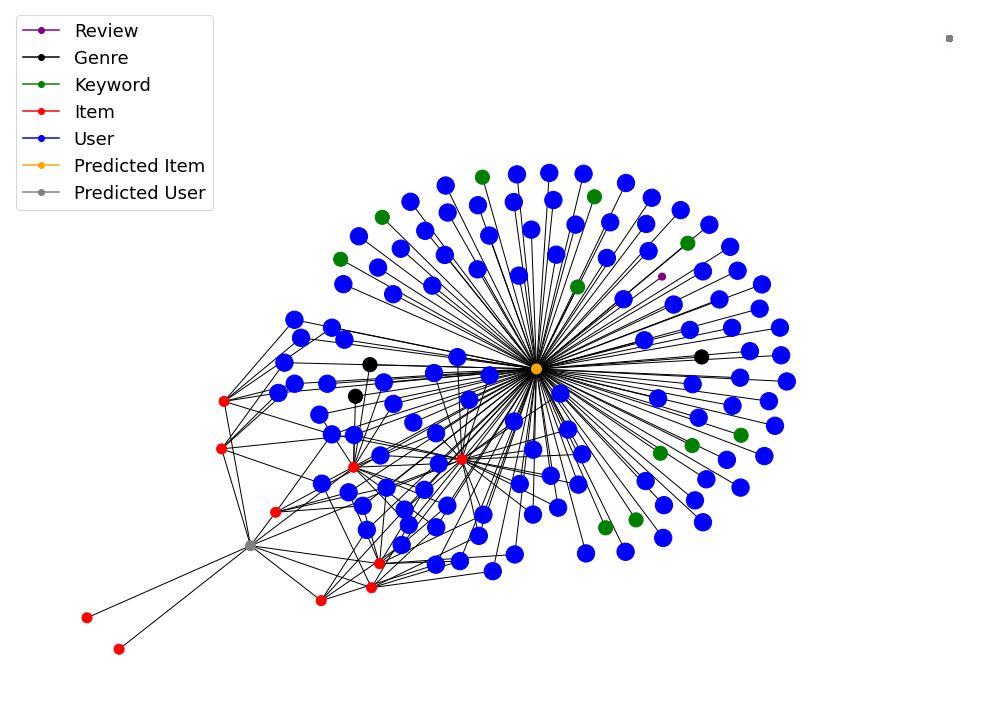

In [ ]:
plot(new_g, node_user, node_item)